# 🍴 Cuisine Prediction Based on Ingredients

In this project, we aim to predict the **cuisine type** based on the list of ingredients in recipes. Using data from [Kaggle's What's Cooking Competition](https://www.kaggle.com/competitions/whats-cooking/overview), we'll dive deep into the flavors of the world through **exploratory data analysis (EDA)** and visualizations. 🌍🍲

Our process is simple yet effective:
1. **Visualize** the dataset to understand ingredient patterns and trends across cuisines. 🧑‍🍳🔍
2. Apply **Natural Language Processing (NLP)** techniques to preprocess and transform ingredient data for machine learning. ✨📊
3. Build and evaluate **XGBClassifier** model, leveraging their predictive power to classify cuisines with precision. 🚀🤖

<div style="text-align: center;">
    <img src="https://t3.ftcdn.net/jpg/04/91/38/74/360_F_491387460_CfL3h5HjOCNkPDcbScAkWvhsCDoooADA.jpg" alt="Image">
</div>

# Importing Packages

In [2]:
import zipfile
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from xgboost import XGBClassifier
from nltk.corpus import stopwords

# Importing and Preprocessing Data

In [3]:
def load_json_from_zip(zip_path, json_file_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(json_file_name) as f:
            return json.load(f)

train = load_json_from_zip('/kaggle/input/whats-cooking/train.json.zip', "train.json")

In [4]:
#converting list to DataFrame
df = pd.DataFrame(train)

# Exploratory Data Analysis

In [5]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [6]:
df.shape

(39774, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


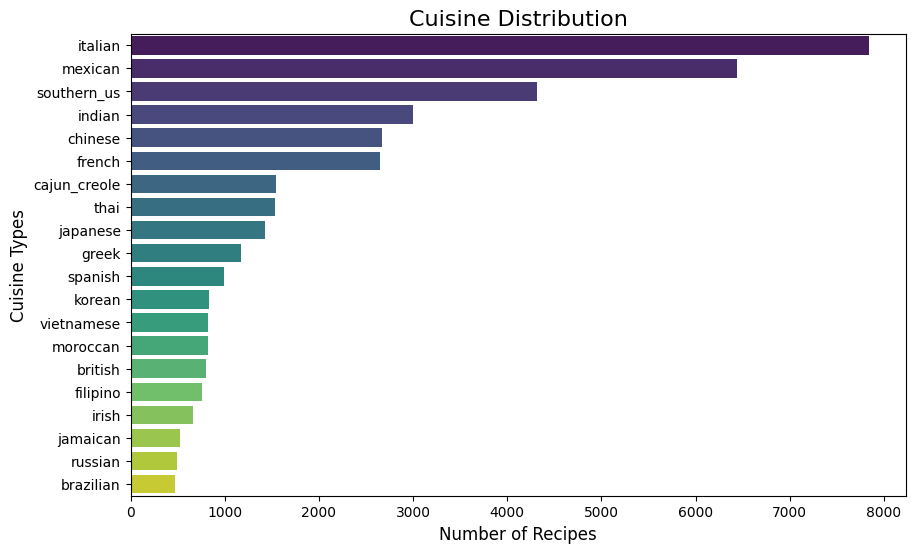

In [8]:
#cuisine distribution
unique_cuisines = df['cuisine'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_cuisines.values, y=unique_cuisines.index, palette="viridis")
plt.title('Cuisine Distribution', fontsize=16)
plt.xlabel('Number of Recipes', fontsize=12)
plt.ylabel('Cuisine Types', fontsize=12)
plt.show()

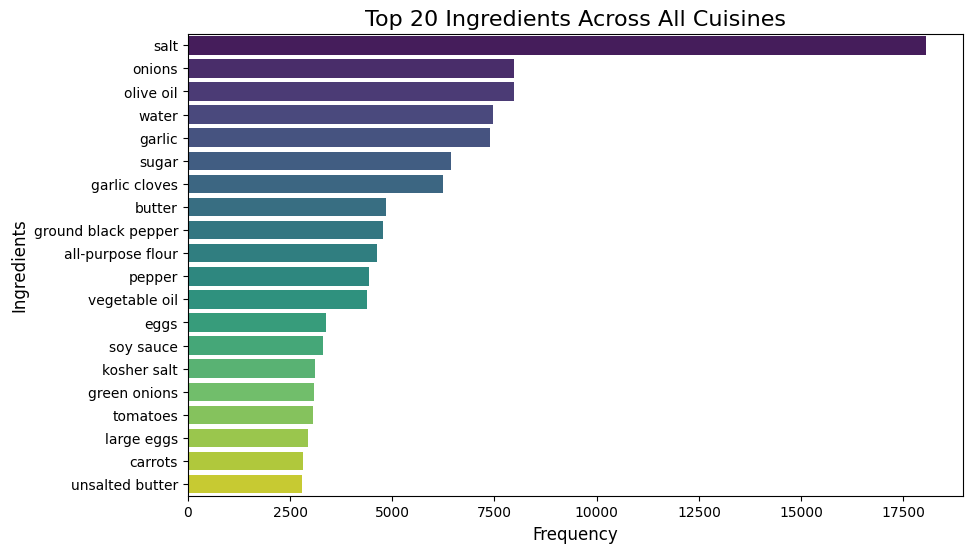

In [9]:
#top 20 ingredients across all cuisines
all_ingredients = df['ingredients'].explode()
ingredient_counts = Counter(all_ingredients)
top_ingredients = ingredient_counts.most_common(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=[count for _, count in top_ingredients], y=[ingredient for ingredient, _ in top_ingredients], palette="viridis")
plt.title("Top 20 Ingredients Across All Cuisines", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Ingredients", fontsize=12)
plt.show()

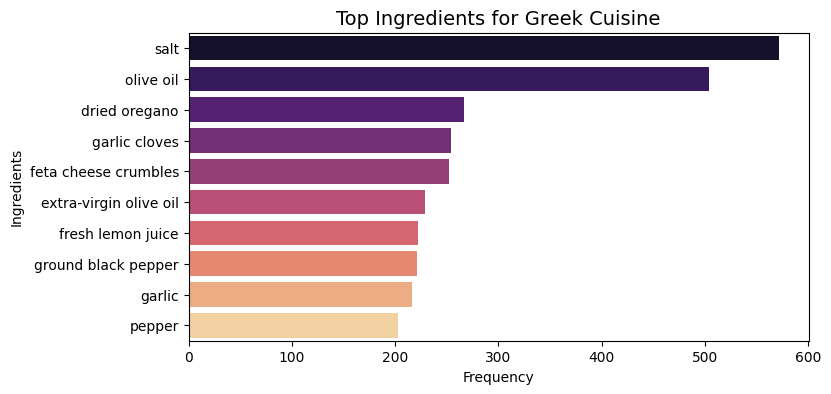

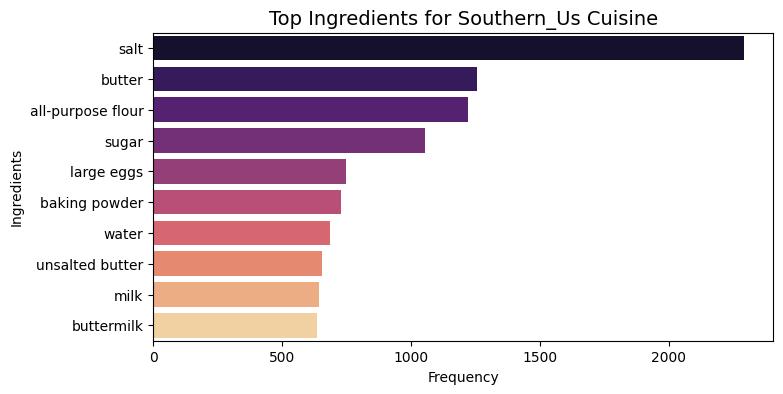

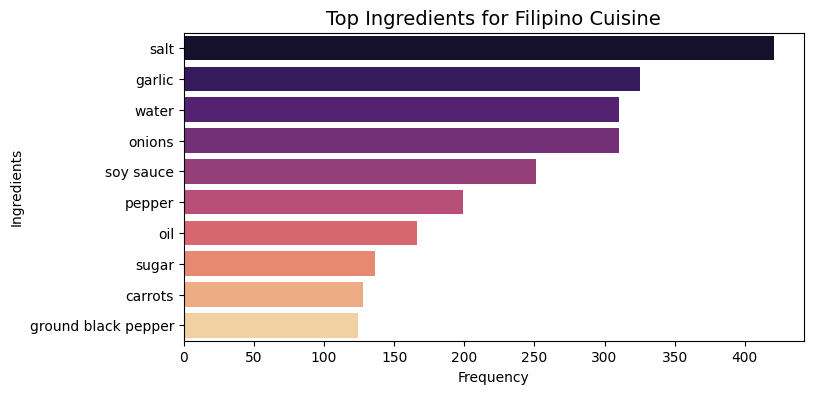

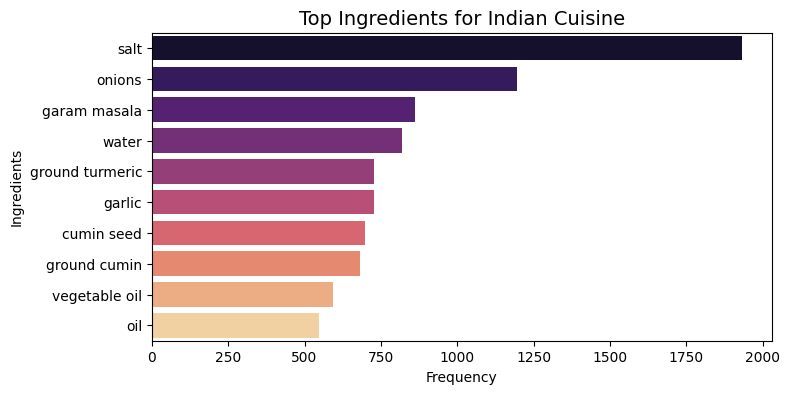

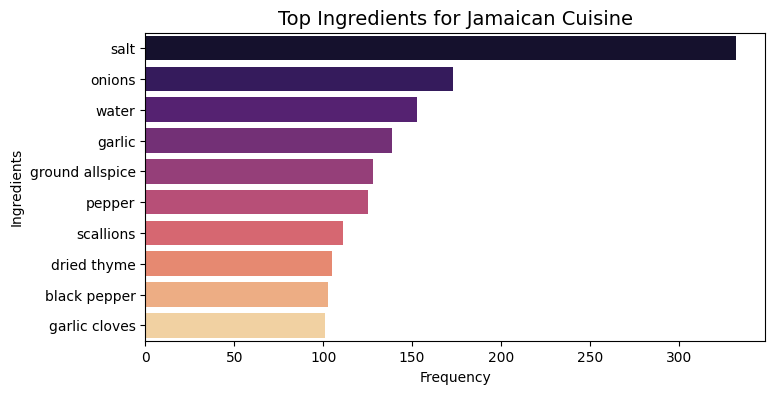

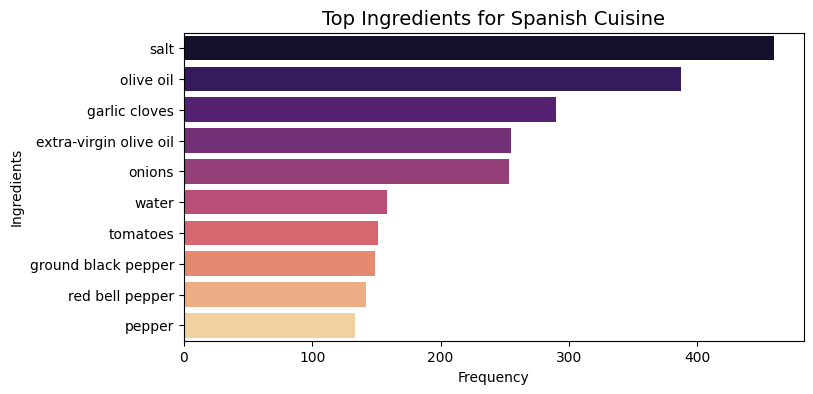

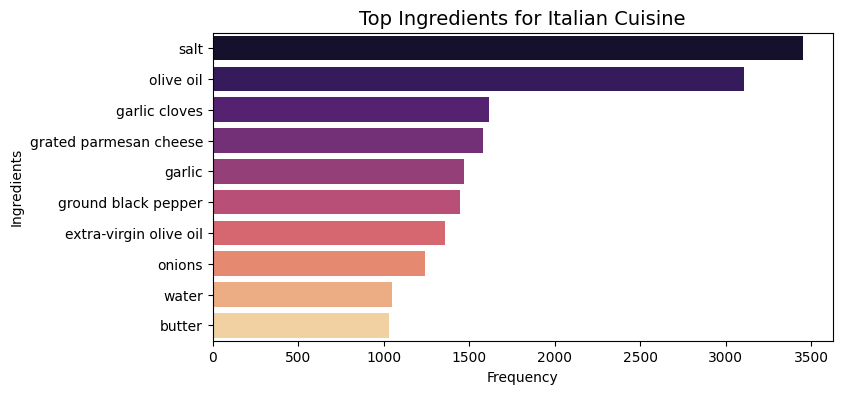

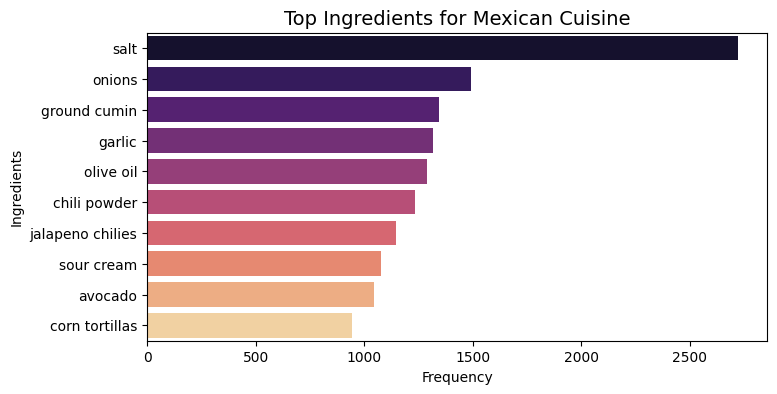

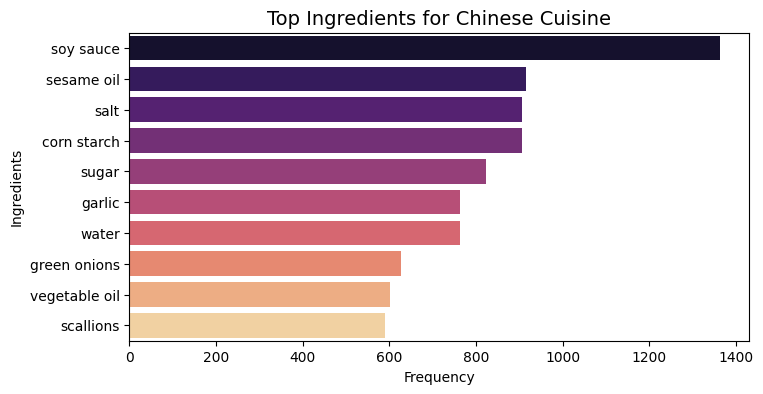

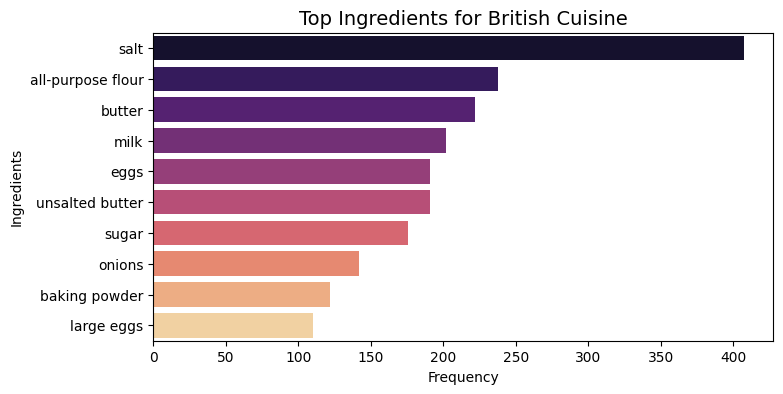

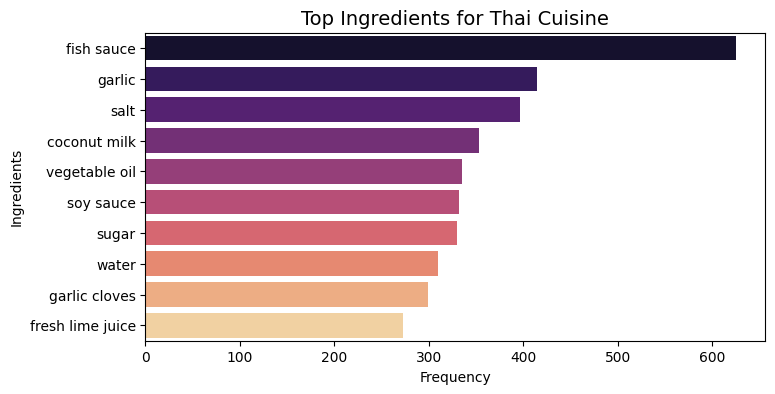

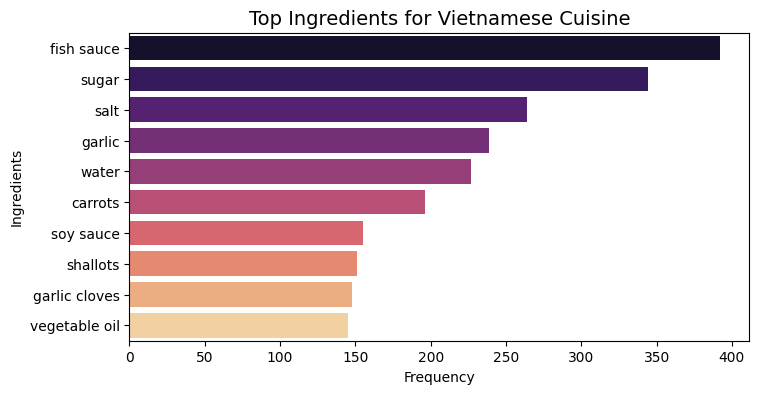

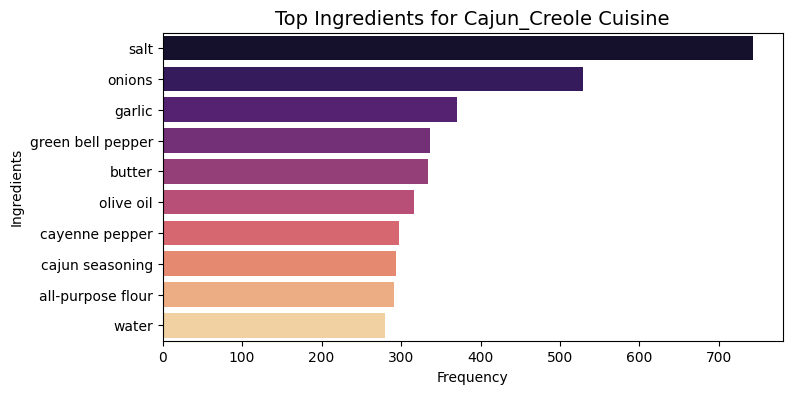

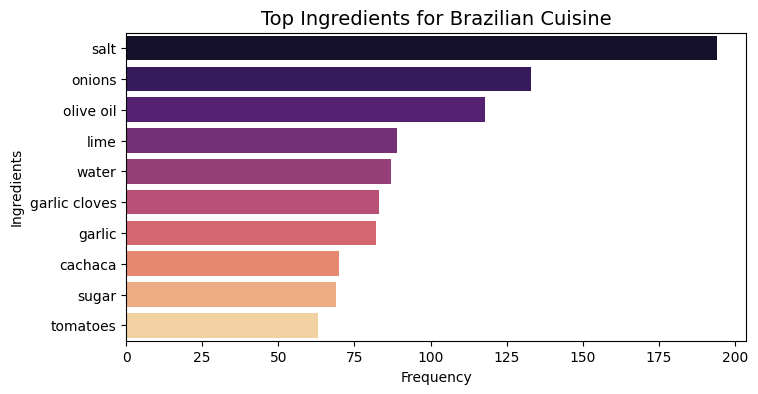

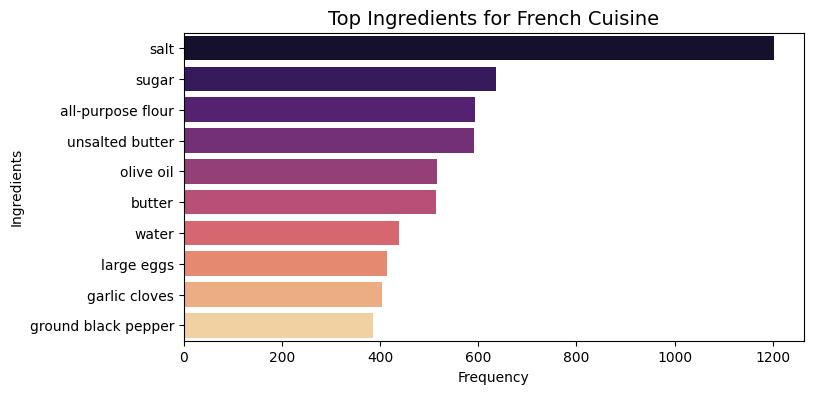

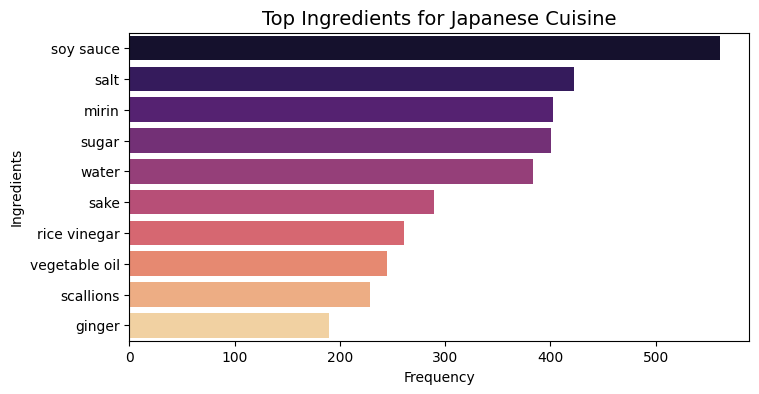

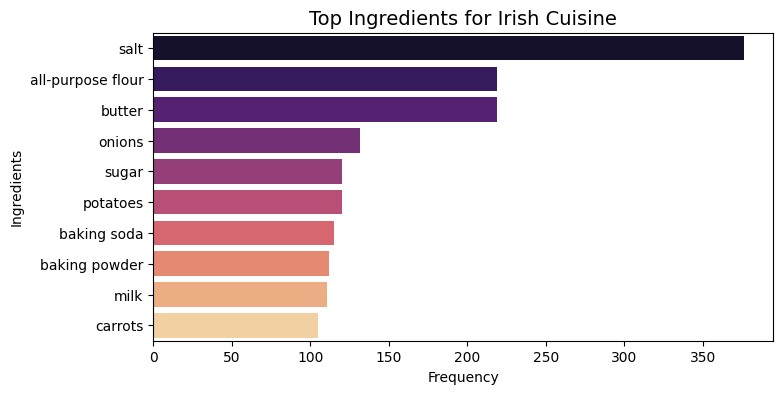

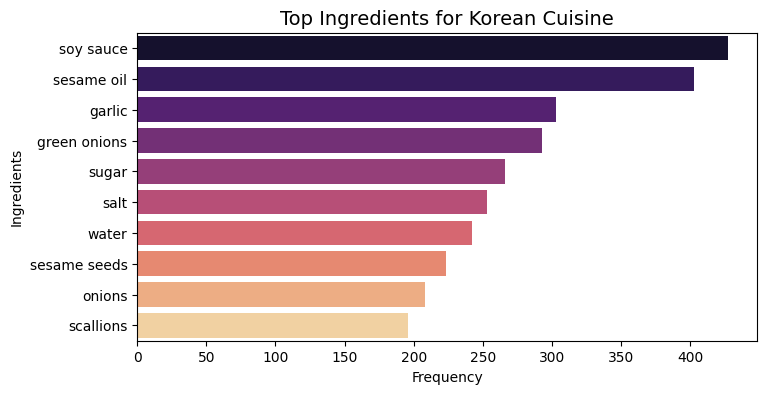

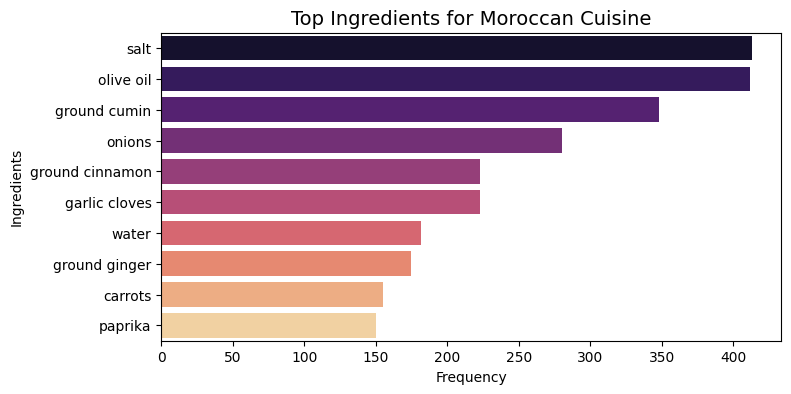

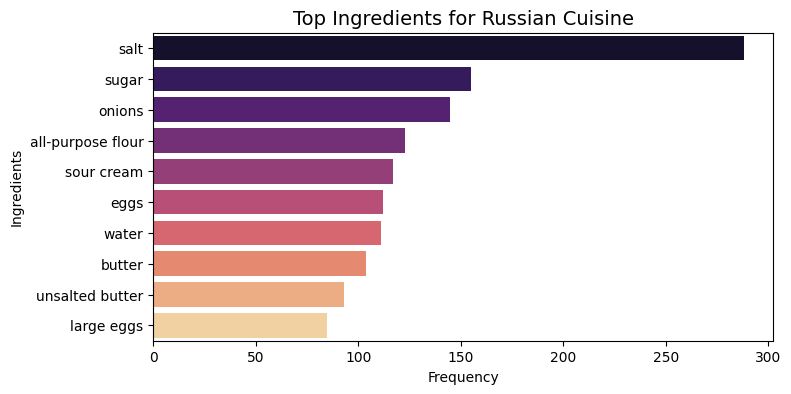

In [10]:
#top ingredients for each cuisine
cuisine_words = {}
for cuisine in df['cuisine'].unique():
    ingredients = df[df['cuisine'] == cuisine]['ingredients'].explode()
    cuisine_words[cuisine] = Counter(ingredients).most_common(10)
for cuisine, words in cuisine_words.items():
    plt.figure(figsize=(8, 4))
    sns.barplot(x=[count for _, count in words], y=[word for word, _ in words], palette="magma")
    plt.title(f"Top Ingredients for {cuisine.title()} Cuisine", fontsize=14)
    plt.xlabel("Frequency", fontsize=10)
    plt.ylabel("Ingredients", fontsize=10)
    plt.show()

# Feature Engineering

In [11]:
#cleaning the text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\(|\)', '', text) 
    text = text.lower() 
    return text

df['ingredients'] = df['ingredients'].apply(lambda x: [clean_text(word) for word in x])

In [12]:
#removing stopwords
stop_words = set(stopwords.words('english'))
df['ingredients'] = df['ingredients'].apply(lambda x: [word for word in x if word not in stop_words])

In [13]:
#combining ingredients into a single string for vectorization
df['ingredients_str'] = df['ingredients'].apply(lambda x: ' '.join(x))

# Modelling with XGBClassifier

In [14]:
#encoding the target
label_encoder = LabelEncoder()
df['cuisine'] = label_encoder.fit_transform(df['cuisine'])

#TF-IDF vectorizing and splitting the data
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df['ingredients_str'])
y = df['cuisine']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
#ML modelling with XGBoost and classification report
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(x_train, y_train)
xgb_pred = xgb_model.predict(x_test)

print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.87      0.56      0.68        84
           1       0.63      0.36      0.46       157
           2       0.81      0.70      0.75       328
           3       0.78      0.84      0.80       510
           4       0.71      0.48      0.57       136
           5       0.60      0.62      0.61       550
           6       0.76      0.67      0.71       249
           7       0.87      0.89      0.88       602
           8       0.69      0.46      0.56       151
           9       0.78      0.90      0.84      1567
          10       0.94      0.67      0.78        91
          11       0.80      0.70      0.75       284
          12       0.84      0.70      0.77       166
          13       0.91      0.93      0.92      1336
          14       0.86      0.75      0.80       166
          15       0.65      0.44      0.52        89
          16       0.68      0.80      0.74       848
          17       0.66    

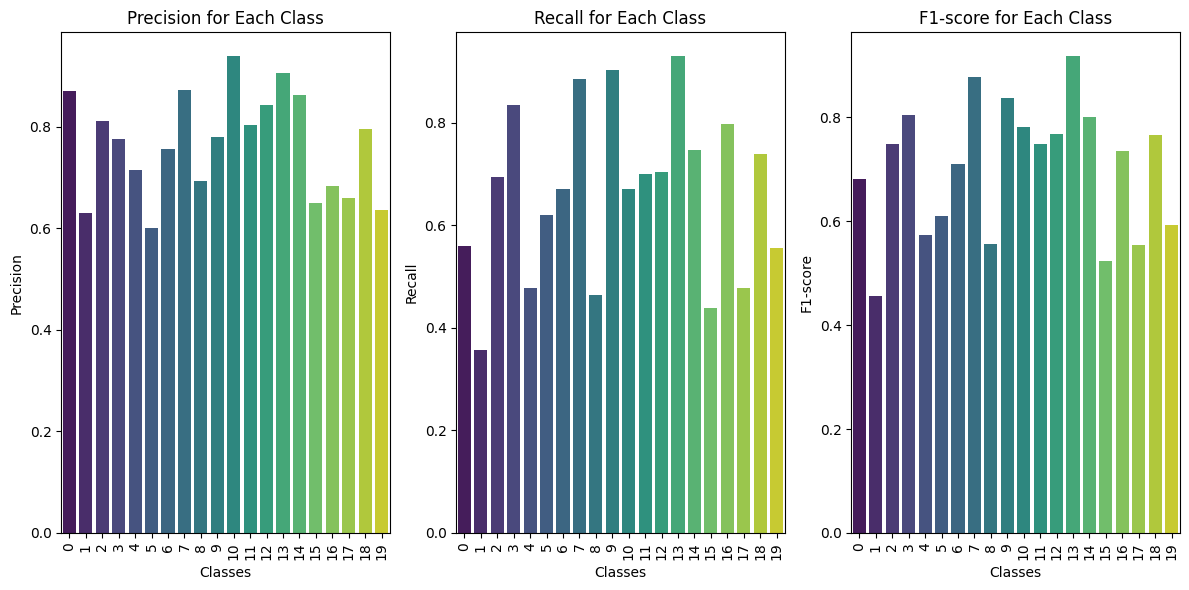

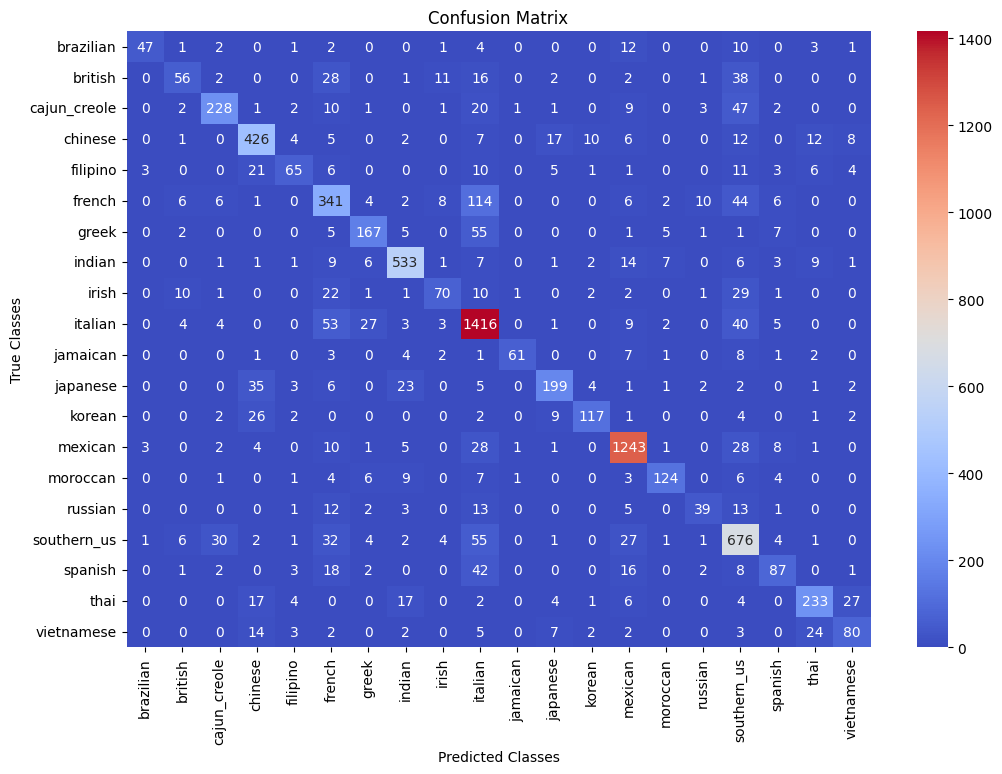

Summary for Weighted Avg Metrics:
Precision: 0.78
Recall: 0.78
F1-Score: 0.78


In [16]:
#confusion matrix, precision, recall, and f1-score plot
report = classification_report(y_test, xgb_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 6))
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=report_df.index[:-3], y=report_df[metric][:-3], palette="viridis")
    plt.xticks(rotation=90)
    plt.title(f'{metric.capitalize()} for Each Class')
    plt.xlabel('Classes')
    plt.ylabel(metric.capitalize())

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()

print("Summary for Weighted Avg Metrics:")
print(f"Precision: {report['weighted avg']['precision']:.2f}")
print(f"Recall: {report['weighted avg']['recall']:.2f}")
print(f"F1-Score: {report['weighted avg']['f1-score']:.2f}")


# 🎯 Conclusion

In this project, we built a machine learning pipeline to predict **cuisine types** based on ingredients, achieving an accuracy of **0.78**. Through **exploratory data analysis**, we uncovered trends in ingredient usage across cuisines, and by leveraging NLP techniques like **TF-IDF** and **cleaning processes**, we transformed the raw data into actionable features. 

---

While our model performed well, there’s still room for improvement:

1. **Handle Imbalance**: Address class imbalance with advanced techniques like **SMOTE** or **weighted loss functions**.
2. **Feature Enrichment**: Incorporate external data such as regional dietary patterns or ingredient hierarchies for richer feature representation.
3. **Hyperparameter Tuning**: Fine-tune model parameters further using **GridSearch** or **Bayesian Optimization**.